In [1]:
import zipfile
with zipfile.ZipFile('/home/mrk9fx/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/home/mrk9fx/dl_data')


In [15]:
import numpy as np
import sys
import pandas as pd 
from keras.layers import Input, Lambda, Dense, Flatten , Dropout , MaxPool2D
from keras.models import Model , Sequential
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
import matplotlib.pyplot as plt
import random
import os
from distutils.file_util import copy_file
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau

In [32]:
covidDataPath='dl_data/COVID_Radiography_Dataset/COVID/images'
pneumoniaDataPath='dl_data/COVID_Radiography_Dataset/Viral/images'
normalDataPath='dl_data/COVID_Radiography_Dataset/Normal/images'
# Lists for access paths

In [33]:
# Lists for access paths
listCovidPaths = []
listViralPaths=[]
listNormalPaths = []

# Get covid images files paths
for root, directories, files in os.walk(covidDataPath):
    for name in files:
        listCovidPaths.append(os.path.join(root, name))

for root, directories, files in os.walk(pneumoniaDataPath):
    for name in files:
        listViralPaths.append(os.path.join(root, name))        
        
# Get normal images files paths
for root, directories, files in os.walk(normalDataPath):
    for name in files:
        listNormalPaths.append(os.path.join(root, name))

# Shuffle lists for random train / test

random.shuffle(listCovidPaths)
random.shuffle(listNormalPaths)
random.shuffle(listViralPaths)

In [35]:
# main folder
!mkdir ./dl_data/Data/

# Train data folders
!mkdir ./dl_data/Data/Train/
!mkdir ./dl_data/Data/Train/Covid/
!mkdir ./dl_data/Data/Train/Normal/
!mkdir ./dl_data/Data/Train/Viral/

# Test data folders
!mkdir ./dl_data/Data/Test/
!mkdir ./dl_data/Data/Test/Covid/
!mkdir ./dl_data/Data/Test/Normal/
!mkdir ./dl_data/Data/Test/Viral/

# Valid data folders
!mkdir ./dl_data/Data/Valid/
!mkdir ./dl_data/Data/Valid/Covid/
!mkdir ./dl_data/Data/Valid/Normal/
!mkdir ./dl_data/Data/Valid/Viral/

# Paths to covid images folders
pathCovidTrain = './dl_data/Data/Train/Covid/'
pathCovidTest = './dl_data/Data/Test/Covid/'
pathCovidValid='./dl_data/Data/Valid/Covid/'


# Paths to normal images folders
pathNormalTrain = './dl_data/Data/Train/Normal/'
pathNormalTest = './dl_data/Data/Test/Normal/'
pathNormalValid='./dl_data/Data/Valid/Normal/'

# Paths to viral image foldrs
pathViralTrain = './dl_data/Data/Train/Viral/'
pathViralTest = './dl_data/Data/Test/Viral/'
pathViralValid='./dl_data/Data/Valid/Viral/'

In [37]:
len(listCovidPaths)

3617

In [38]:
# Move covid images files to new folders
for i in range(3617):
    if i < 2893:
        copy_file(listCovidPaths[i], pathCovidTrain)
    elif i>=2893 and i<=3255:
        copy_file(listCovidPaths[i], pathCovidValid)
    else  : 
        copy_file(listCovidPaths[i], pathCovidTest)
        
for i in range(10192):
    if i < 8154:
        copy_file(listNormalPaths[i], pathNormalTrain)
    elif i>=8154 and i<=9174:
        copy_file(listNormalPaths[i], pathNormalValid)     
    else  : 
        copy_file(listNormalPaths[i], pathNormalTest)       

                
for i in range(1345):
    if i < 402:
        copy_file(listViralPaths[i], pathViralTrain)
    elif i>=402 and i<=552:
        copy_file(listViralPaths[i], pathViralValid)     
    else  : 
        copy_file(listViralPaths[i], pathViralTest)     

# Start Here

In [40]:
train_data_gen = ImageDataGenerator(rescale=1./255 ,
                                    zoom_range= 0.3, 
                                    horizontal_flip= True, 
                                    shear_range= 0.2,
                                    rotation_range = 30
                                    )

train = train_data_gen.flow_from_directory(directory= 'dl_data/Data/Train',
                                           class_mode = 'binary',
                                           batch_size=64,
                                           target_size=(224,224))  

Found 11449 images belonging to 3 classes.


In [41]:
test_data_gen = ImageDataGenerator(rescale=1./255 )

test = test_data_gen.flow_from_directory(directory= 'dl_data/Data/Test' , 
                                          target_size=(224,224), 
                                            class_mode = 'binary',
                                        shuffle=False,
                                        batch_size=64)

valid = test_data_gen.flow_from_directory(directory= 'dl_data/Data/Valid' , 
                                          target_size=(224,224), 
                                            class_mode = 'binary',
                                        shuffle=False,
                                        batch_size=64)

Found 2170 images belonging to 3 classes.
Found 1535 images belonging to 3 classes.


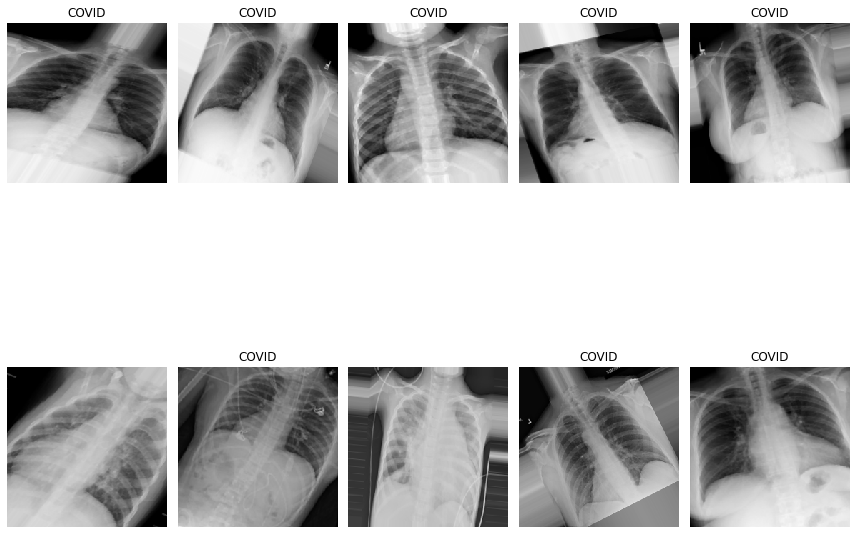

In [42]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'COVID'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

# Resnet

In [43]:
inc = tf.keras.applications.resnet50.ResNet50(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3),
    classifier_activation = 'sigmoid'
)

In [44]:
for layer in inc.layers:           
  layer.trainable = False

In [45]:
'''
Definition of the Keras model outputs
'''

x = Flatten()(inc.output)
prediction= Dense(units=1 , activation='sigmoid')(x)

model = Model(inc.input,prediction)


"""
Compile model
"""

model.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss = 'binary_crossentropy',
    
    metrics = ['accuracy']
)

In [46]:
early = EarlyStopping(monitor='val_accuracy', mode='min', patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.0001)
callbacks_list = [ early, learning_rate_reduction]


In [47]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced',np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.3191611936859085, 1: 0.46803204970975393, 2: 9.493366500829188}


In [59]:
hist = model.fit(train, steps_per_epoch= len(train)//5, epochs= 5, validation_data= valid, class_weight=cw,validation_steps= len(test)//5, callbacks=callbacks_list)

Epoch 1/5
35/35 [==============================] - 117s 3s/step - loss: -6.7953 - accuracy: 0.7071 - val_loss: 85.8899 - val_accuracy: 0.0573 - lr: 3.0000e-04
Epoch 2/5
35/35 [==============================] - 117s 3s/step - loss: -9.4721 - accuracy: 0.7219 - val_loss: 97.7946 - val_accuracy: 0.0547 - lr: 3.0000e-04
Epoch 3/5
35/35 [==============================] - ETA: 0s - loss: -20.0716 - accuracy: 0.7179
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0001.
35/35 [==============================] - 117s 3s/step - loss: -20.0716 - accuracy: 0.7179 - val_loss: 134.5506 - val_accuracy: 0.0547 - lr: 3.0000e-04
Epoch 4/5
35/35 [==============================] - 117s 3s/step - loss: -15.9460 - accuracy: 0.7058 - val_loss: 140.1615 - val_accuracy: 0.0547 - lr: 1.0000e-04
Epoch 5/5
35/35 [==============================] - 117s 3s/step - loss: -12.4938 - accuracy: 0.7165 - val_loss: 144.7164 - val_accuracy: 0.0547 - lr: 1.0000e-04


In [60]:
len(train)//10

17